In [1]:
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from pyspark.sql import SparkSession
import pyspark.sql.functions as func
from pyspark.sql.types import FloatType
from pyspark.sql.window import Window
import geopandas

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("PySpark") \
    .getOrCreate()

with zipfile.ZipFile("/home/dmitry/Desktop/BigData/src/data/GlobalLandTemperaturesByMajorCity.csv.zip") as z:
    with z.open("GlobalLandTemperaturesByMajorCity.csv") as f:
        pandas_df = pd.read_csv(f)
        df = spark.createDataFrame(pandas_df)

df.show(10)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/24 23:04:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/05/24 23:04:49 WARN TaskSetManager: Stage 0 contains a task of very large size (1256 KiB). The maximum recommended task size is 1000 KiB.


+----------+------------------+-----------------------------+-------+-------------+--------+---------+
|        dt|AverageTemperature|AverageTemperatureUncertainty|   City|      Country|Latitude|Longitude|
+----------+------------------+-----------------------------+-------+-------------+--------+---------+
|1849-01-01|            26.704|                        1.435|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1849-02-01|            27.434|                        1.362|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1849-03-01|            28.101|                        1.612|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1849-04-01|             26.14|           1.3869999999999998|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1849-05-01|            25.427|                          1.2|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1849-06-01|            24.844|                        1.402|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1849-07-01|24.058000000000003|                        1.254|Abidjan|Côte

# Задание 3.1 (1 балл)

В последующих заданиях будут учитываться данные начиная с 01.01.1950. Для этого создайте новый `DataFrame`, в котором удалены все строки до 01.01.1950. Используйте созданный DataFrame в последующих заданиях.  

In [3]:
weather_df = df.filter(func.col("dt") >= "1850-01-01")

weather_df.show(10)

23/05/24 23:04:50 WARN TaskSetManager: Stage 1 contains a task of very large size (1256 KiB). The maximum recommended task size is 1000 KiB.


+----------+------------------+-----------------------------+-------+-------------+--------+---------+
|        dt|AverageTemperature|AverageTemperatureUncertainty|   City|      Country|Latitude|Longitude|
+----------+------------------+-----------------------------+-------+-------------+--------+---------+
|1850-01-01|            25.803|                        1.943|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1850-02-01|             27.89|                         1.43|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1850-03-01|            27.852|                        2.173|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1850-04-01|            26.547|                        1.662|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1850-05-01|            25.379|                        1.355|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1850-06-01|            24.903|                        1.178|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1850-07-01|24.040000000000006|                        1.301|Abidjan|Côte

# Задание 3.2 (2 балла)

Постройте график среднегодовых температур в городе Торонто.

23/05/24 23:04:52 WARN TaskSetManager: Stage 2 contains a task of very large size (1256 KiB). The maximum recommended task size is 1000 KiB.


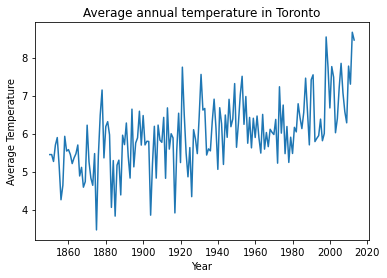

In [4]:
toronto_df = weather_df.filter(func.col("City") == "Toronto")
toronto_average_annual_temp = toronto_df.withColumn("year", func.year(func.col("dt"))) \
    .groupBy("year") \
    .agg(func.avg("AverageTemperature").alias("AverageTemperature")).orderBy("year")

data = toronto_average_annual_temp.toPandas()

plt.plot(data["year"], data["AverageTemperature"])
plt.title("Average annual temperature in Toronto")
plt.xlabel("Year")
plt.ylabel("Average Temperature")
plt.show()

# Задание 3.3 (2 балла)

Найдите город, для которого выборочная дисперсия температур на приведенных данных максимальна. 

In [5]:
temp_variance = weather_df.dropna().groupBy("City", "Latitude") \
                          .agg(func.variance(func.col("AverageTemperature")) \
                          .alias("TemperatureVariance"))

temp_variance.orderBy(func.col("TemperatureVariance").desc()).first()

23/05/24 23:04:56 WARN TaskSetManager: Stage 10 contains a task of very large size (1256 KiB). The maximum recommended task size is 1000 KiB.


Row(City='Harbin', Latitude='45.81N', TemperatureVariance=225.60277382586736)

# Задание 3.4 (4 балла)

На одной оси постройте графики, отображающие:
1. Зависимость выборочной дисперсии температур от широты города (Latitude).
2. Зависимость средней температуры в январе 1975 года от широты города (Latitude).
3. Зависимость средней температуры в июле 1975 года от широты города (Latitude).

In [6]:
def mean_year_month_temp(year: int = 1975, month: int = 1):
    date = weather_df.filter((func.year(weather_df.dt) == year) & (func.month(weather_df.dt) == month))
    mean_temp_in_month = date.dropna().groupBy("City", "Latitude") \
                             .agg(func.mean(func.col("AverageTemperature")) \
                             .alias("AverageTemperature"))
    return mean_temp_in_month

mean_temp_january_1975 = mean_year_month_temp(year=1975, month=1)
mean_temp_july_1975 = mean_year_month_temp(year=1975, month=7)

In [7]:
df_for_graph = temp_variance.withColumn("Side", func.substring(temp_variance["Latitude"], -1, 1))
df_for_graph = df_for_graph.join(mean_temp_january_1975, on=["City", "Latitude"], how="left") \
                           .withColumnRenamed("AverageTemperature", "AverageTemperatureInJanuary1975")
df_for_graph = df_for_graph.join(mean_temp_july_1975, on=["City", "Latitude"], how="left") \
                           .withColumnRenamed("AverageTemperature", "AverageTemperatureInJuly1975")

df_for_graph = df_for_graph.withColumn("Latitude", func.expr("substring(Latitude, 1, length(Latitude)-1)").cast(FloatType()))
df_for_graph = df_for_graph.withColumn("Latitude", func.expr("IF(Side = 'S', -1 * Latitude, Latitude)"))
df_for_graph = df_for_graph.orderBy("Latitude")
df_for_graph.show(10)

23/05/24 23:05:04 WARN TaskSetManager: Stage 13 contains a task of very large size (1256 KiB). The maximum recommended task size is 1000 KiB.
23/05/24 23:05:05 WARN TaskSetManager: Stage 14 contains a task of very large size (1256 KiB). The maximum recommended task size is 1000 KiB.
23/05/24 23:05:06 WARN TaskSetManager: Stage 15 contains a task of very large size (1256 KiB). The maximum recommended task size is 1000 KiB.


+--------------+--------+-------------------+----+-------------------------------+----------------------------+
|          City|Latitude|TemperatureVariance|Side|AverageTemperatureInJanuary1975|AverageTemperatureInJuly1975|
+--------------+--------+-------------------+----+-------------------------------+----------------------------+
|     Melbourne|  -37.78| 15.956456466298112|   S|                         17.305|                       9.868|
|        Sydney|  -34.56|  4.793517359277645|   S|                         19.328|                      15.098|
|     Cape Town|  -32.95|  8.961925301894643|   S|                         19.827|                      11.742|
|      Santiago|  -32.95| 22.526324735324355|   S|                         12.468|                      -1.101|
|        Durban|  -29.74|   3.87022568549758|   S|                         22.529|                      17.711|
|     São Paulo|  -23.31|  6.271975736223708|   S|                          21.93|                      

23/05/24 23:05:08 WARN TaskSetManager: Stage 22 contains a task of very large size (1256 KiB). The maximum recommended task size is 1000 KiB.
23/05/24 23:05:09 WARN TaskSetManager: Stage 23 contains a task of very large size (1256 KiB). The maximum recommended task size is 1000 KiB.
23/05/24 23:05:09 WARN TaskSetManager: Stage 24 contains a task of very large size (1256 KiB). The maximum recommended task size is 1000 KiB.


<AxesSubplot:xlabel='Latitude', ylabel='Temperature'>

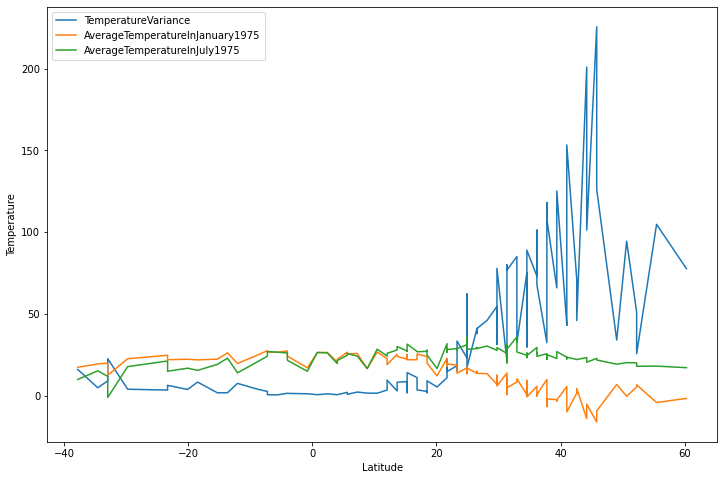

In [8]:
data = df_for_graph.toPandas()

data.plot(
    x="Latitude", 
    y=["TemperatureVariance", "AverageTemperatureInJanuary1975", "AverageTemperatureInJuly1975"], 
    figsize=(12,8),
    ylabel="Temperature"
)

# Задание 3.5 (6 баллов)

Посчитайте данные по среднегодовой температуре в Санкт-Петербурге. Определите года, в которых средняя температура была выше, чем в предыдущем  и последующем году. Постройте график среднегодовой температуры и обозначьте на нём найденные года (произвольным образом). 

Постройте модель линейной регрессии (можно использовать [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)): $\mathbb{год} \rightarrow \mathbb{средняя\_температура}$. Отобразите прямую на предыдущем графике. 

In [9]:
saint_petersburg_df = weather_df.filter(func.col("City") == "Saint Petersburg").na.drop()
saint_petersburg_df = saint_petersburg_df.withColumn("Year", func.year(saint_petersburg_df["dt"]))

In [10]:
saint_p_average_annual_temp = saint_petersburg_df.groupBy("Year") \
                                                 .agg(func.mean("AverageTemperature").alias("MeanTemperature")) \
                                                 .orderBy("Year")

In [11]:
window = Window.orderBy("Year")
saint_p_average_annual_temp = saint_p_average_annual_temp \
    .withColumn("+deltaMeanTemperature", func.col("MeanTemperature") - func.lag("MeanTemperature").over(window)) \
    .withColumn("-deltaMeanTemperature", func.col("MeanTemperature") - func.lead("MeanTemperature").over(window))

positive_years = saint_p_average_annual_temp.filter((func.col("+deltaMeanTemperature") > 0) & (func.col("-deltaMeanTemperature") > 0))

x_values = positive_years.select("Year").rdd.flatMap(lambda x: x).collect()
y_values = positive_years.select("MeanTemperature").rdd.flatMap(lambda x: x).collect()

23/05/24 23:05:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/24 23:05:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/24 23:05:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/24 23:05:16 WARN TaskSetManager: Stage 36 contains a task of very large size (1256 KiB). The maximum recommended task size is 1000 KiB.
23/05/24 23:05:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/24 23:05:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/24 23:05:17 WARN WindowExec

23/05/24 23:05:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/24 23:05:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/24 23:05:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/24 23:05:25 WARN TaskSetManager: Stage 60 contains a task of very large size (1256 KiB). The maximum recommended task size is 1000 KiB.
23/05/24 23:05:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/24 23:05:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/24 23:05:25 WARN WindowExec

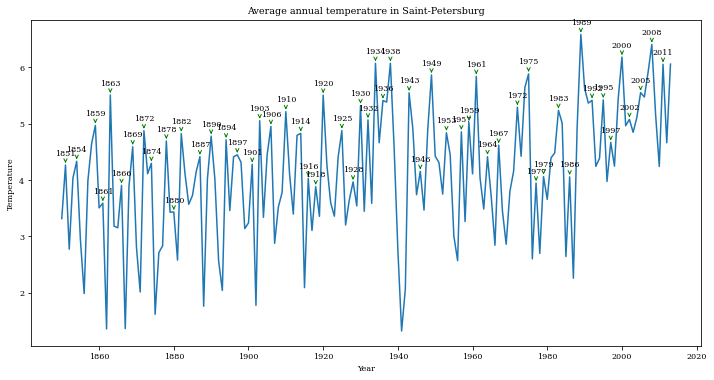

In [12]:
def average_annual_temp(df, xval, yval):
    fig = plt.gcf()
    fig.set_size_inches(12, 6)
    font = {'family' : 'serif','weight' : 'light','size': 8}
    plt.rc('font', **font)

    plt.plot(df["Year"], df["MeanTemperature"])

    plt.xlabel("Year")
    plt.ylabel("Temperature")
    plt.title("Average annual temperature in Saint-Petersburg")

    for x,y in zip(xval, yval):
        label = x
        
        plt.annotate(
            label, 
            (x,y),
            textcoords="offset points",
            xytext=(0,10),
            ha='center',
            arrowprops=dict(arrowstyle="->", color='green'),
        )

data = saint_p_average_annual_temp.toPandas()
average_annual_temp(data, x_values, y_values)

In [13]:
data

,Year,MeanTemperature,+deltaMeanTemperature,-deltaMeanTemperature
0,1850,3.312500,NaN,-0.952667
1,1851,4.265167,0.952667,1.494167
2,1852,2.771000,-1.494167,-1.266500
3,1853,4.037500,1.266500,-0.294167
4,1854,4.331667,0.294167,1.401167
...,...,...,...,...
159,2009,5.177417,-1.231000,0.937500
160,2010,4.239917,-0.937500,-1.816333
161,2011,6.056250,1.816333,1.395250
162,2012,4.661000,-1.395250,-1.397750


Coefficients: 
 [0.00737165]
Mean squared error: 0.85


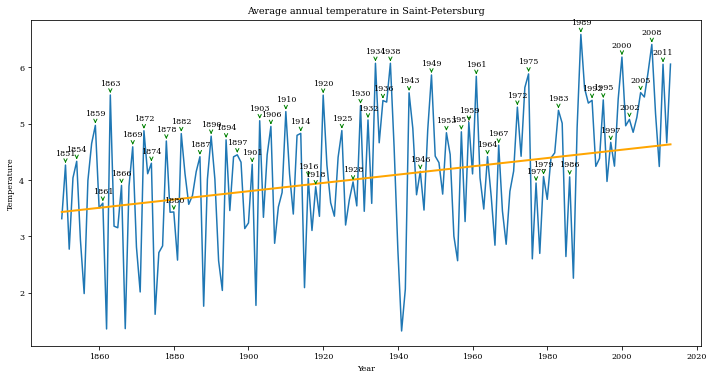

In [14]:
X = np.array(data["Year"])
y = np.array(data["MeanTemperature"])
X = X.reshape(-1, 1)

X_train = X[:-20]
X_test = X[-20:]
y_train = y[:-20]
y_test = y[-20:]

regr = LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

print("Coefficients: \n", regr.coef_)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))

average_annual_temp(data, x_values, y_values)
plt.plot(X, regr.predict(X), color="orange", linewidth=2)
plt.show()

# Задание 3.6 (4 балла)

Найдите города, для которых: 
1. Разница между максимальным и минимальным значением среднегодовой температуры в выборке максимальна.
2. Самая большая средняя разница между средней температурой января и средней температурой июля.
3. Наибольшее среднее количество дней с отрицательной температурой в году.

1. Разница между максимальным и минимальным значением среднегодовой температуры в выборке максимальна.

In [15]:
weather_df.show()

+----------+------------------+-----------------------------+-------+-------------+--------+---------+
|        dt|AverageTemperature|AverageTemperatureUncertainty|   City|      Country|Latitude|Longitude|
+----------+------------------+-----------------------------+-------+-------------+--------+---------+
|1850-01-01|            25.803|                        1.943|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1850-02-01|             27.89|                         1.43|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1850-03-01|            27.852|                        2.173|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1850-04-01|            26.547|                        1.662|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1850-05-01|            25.379|                        1.355|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1850-06-01|            24.903|                        1.178|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1850-07-01|24.040000000000006|                        1.301|Abidjan|Côte

23/05/24 23:05:33 WARN TaskSetManager: Stage 72 contains a task of very large size (1256 KiB). The maximum recommended task size is 1000 KiB.


In [16]:
new_weather_df = weather_df.na.drop()
new_weather_df = new_weather_df.withColumn("Year", func.year(new_weather_df["dt"]))
new_weather_df = new_weather_df.withColumn("Month", func.month(new_weather_df["dt"]))
average_annual_temperature = new_weather_df.groupby(["City", "Year"]) \
                                           .agg({"AverageTemperature": "mean"}) \
                                           .withColumnRenamed("avg(AverageTemperature)", "AverageAnnualTemperature")

min_max_annual_temp = average_annual_temperature.groupby("City") \
                                                .agg(func.max("AverageAnnualTemperature").alias("MaxAnnualTemperature"), 
                                                     func.min("AverageAnnualTemperature").alias("MinAnnualTemperature"))

min_max_annual_temp = min_max_annual_temp.withColumn(
    "DifferenceTemperature",
    min_max_annual_temp["MaxAnnualTemperature"] - min_max_annual_temp["MinAnnualTemperature"]
)

max_difference = min_max_annual_temp.select(func.max("DifferenceTemperature")).first()[0]
city_with_max_difference = min_max_annual_temp \
    .filter(min_max_annual_temp["DifferenceTemperature"] == max_difference) \
    .select("City").first()[0]

print(max_difference)
print(city_with_max_difference)

23/05/24 23:05:34 WARN TaskSetManager: Stage 73 contains a task of very large size (1256 KiB). The maximum recommended task size is 1000 KiB.
23/05/24 23:05:36 WARN TaskSetManager: Stage 83 contains a task of very large size (1256 KiB). The maximum recommended task size is 1000 KiB.


6.4005833333333335
Calcutta


2. Самая большая средняя разница между средней температурой января и средней температурой июля.

In [17]:
def mean_month_temp(month):
    date = new_weather_df.filter(new_weather_df["Month"] == month)
    mean_temp_in_month = date.groupby("City").agg({"AverageTemperature": "mean"}) \
                             .withColumnRenamed("avg(AverageTemperature)", f"MeanTemperature_{month}")
    return mean_temp_in_month

df_january = mean_month_temp(month=1)
df_july = mean_month_temp(month=7)
df_diff = df_january.join(df_july, on=["City"], how="left")
df_diff = df_diff.withColumn("DifferenceTemperature", func.abs(func.col("MeanTemperature_1") - func.col("MeanTemperature_7")))

max_difference = df_diff.select(func.max("DifferenceTemperature")).first()[0]
city_with_max_difference = df_diff.filter(df_diff["DifferenceTemperature"] == max_difference).select("City").first()[0]

print(max_difference)
print(city_with_max_difference)

23/05/24 23:05:39 WARN TaskSetManager: Stage 89 contains a task of very large size (1256 KiB). The maximum recommended task size is 1000 KiB.
23/05/24 23:05:39 WARN TaskSetManager: Stage 90 contains a task of very large size (1256 KiB). The maximum recommended task size is 1000 KiB.
23/05/24 23:05:41 WARN TaskSetManager: Stage 98 contains a task of very large size (1256 KiB). The maximum recommended task size is 1000 KiB.
23/05/24 23:05:41 WARN TaskSetManager: Stage 99 contains a task of very large size (1256 KiB). The maximum recommended task size is 1000 KiB.


42.887707317073165
Harbin


3. Наибольшее среднее количество месяцев с отрицательной температурой в году.

In [18]:
temperature_below_zero = new_weather_df \
    .groupby("City", "Year") \
    .agg(func.sum(func.when(func.col("AverageTemperature") < 0, 1).otherwise(0)).alias("count"))

mean_month_count = temperature_below_zero \
    .groupby("City") \
    .agg(func.avg("count").alias("MeanMonthCount"))

max_count = mean_month_count.agg({"MeanMonthCount": "max"}).collect()[0][0]
max_city = mean_month_count.filter(func.col("MeanMonthCount") == max_count).select("City").first()[0]

print(max_count)
print(max_city)

23/05/24 23:05:43 WARN TaskSetManager: Stage 104 contains a task of very large size (1256 KiB). The maximum recommended task size is 1000 KiB.
23/05/24 23:05:44 WARN TaskSetManager: Stage 114 contains a task of very large size (1256 KiB). The maximum recommended task size is 1000 KiB.


4.963414634146342
Harbin


# Задание 3.7 (3 балла)

Отобразите города на карте, например с помощью [geopandas/folium](https://geopandas.org/en/stable/gallery/plotting_with_folium.html) или [plotly](https://plotly.com/python-api-reference/generated/plotly.express.scatter_geo.html). Причем цвет метки должен соответствовать средней температуре в январе за последние 10 лет. 

In [19]:
heatmap = new_weather_df.filter(new_weather_df["Year"]>=2004)
heatmap = heatmap.filter(heatmap["Month"]==1)
heatmap = heatmap.groupBy("City", "Country", "Latitude", "Longitude") \
                 .agg({"AverageTemperature": "mean"}) \
                 .withColumnRenamed("avg(AverageTemperature)", "AverageTemperature")

heatmap = heatmap.withColumn("LatitudeSide", func.col("Latitude").substr(-1, 1))
heatmap = heatmap.withColumn("LongitudeSide", func.col("Longitude").substr(-1, 1))

heatmap = heatmap.withColumn("Latitude", func.expr("substring(Latitude, 1, length(Latitude)-1)").cast(FloatType()))
heatmap = heatmap.withColumn("Longitude", func.expr("substring(Longitude, 1, length(Longitude)-1)").cast(FloatType()))

heatmap = heatmap.withColumn("Latitude", func.when(func.col("LatitudeSide") == "S", -func.col("Latitude")).otherwise(func.col("Latitude")))
heatmap = heatmap.withColumn("Longitude", func.when(func.col("LongitudeSide") == "W", -func.col("Longitude")).otherwise(func.col("Longitude")))


heatmap = heatmap.drop("LatitudeSide", "LongitudeSide")

heatmap.show()

23/05/24 23:05:46 WARN TaskSetManager: Stage 120 contains a task of very large size (1256 KiB). The maximum recommended task size is 1000 KiB.


+--------------+-------------+--------+---------+-------------------+
|          City|      Country|Latitude|Longitude| AverageTemperature|
+--------------+-------------+--------+---------+-------------------+
|     Ahmadabad|        India|   23.31|    72.52|            19.9577|
|   Addis Abeba|     Ethiopia|    8.84|    38.11| 18.223900000000004|
|       Bangkok|     Thailand|   13.66|    99.91| 25.754399999999997|
|Belo Horizonte|       Brazil|  -20.09|   -44.36|            23.2978|
|       Baghdad|         Iraq|   32.95|     45.0| 10.115300000000001|
|        Berlin|      Germany|   52.24|    13.14|             0.5474|
|       Abidjan|Côte D'Ivoire|    5.63|    -3.23| 27.283000000000005|
|    Alexandria|        Egypt|   31.35|    30.16|            14.8218|
|        Ankara|       Turkey|   39.38|    33.29|-0.6110000000000001|
|     Bangalore|        India|   12.05|    77.26| 23.564100000000003|
|        Aleppo|        Syria|   36.17|    37.79|             5.9257|
|         Dakar|    

In [20]:
data = heatmap.toPandas()
geometry = geopandas.points_from_xy(data["Longitude"], data["Latitude"])
geo_df = geopandas.GeoDataFrame(
    data[["City","Country", "AverageTemperature"]], geometry=geometry
)

geo_df

23/05/24 23:05:47 WARN TaskSetManager: Stage 123 contains a task of very large size (1256 KiB). The maximum recommended task size is 1000 KiB.


,City,Country,AverageTemperature,geometry
0,Ahmadabad,India,19.9577,POINT (72.52000 23.31000)
1,Addis Abeba,Ethiopia,18.2239,POINT (38.11000 8.84000)
2,Bangkok,Thailand,25.7544,POINT (99.91000 13.66000)
3,Belo Horizonte,Brazil,23.2978,POINT (-44.36000 -20.09000)
4,Baghdad,Iraq,10.1153,POINT (45.00000 32.95000)
...,...,...,...,...
95,Toronto,Canada,-6.7642,POINT (-80.50000 44.20000)
96,Tianjin,China,-3.8920,POINT (116.53000 39.38000)
97,Xian,China,-2.1035,POINT (108.97000 34.56000)
98,Singapore,Singapore,26.5441,POINT (103.66000 0.80000)


Text(1562.9522222222224, 0.5, 'Temperature')

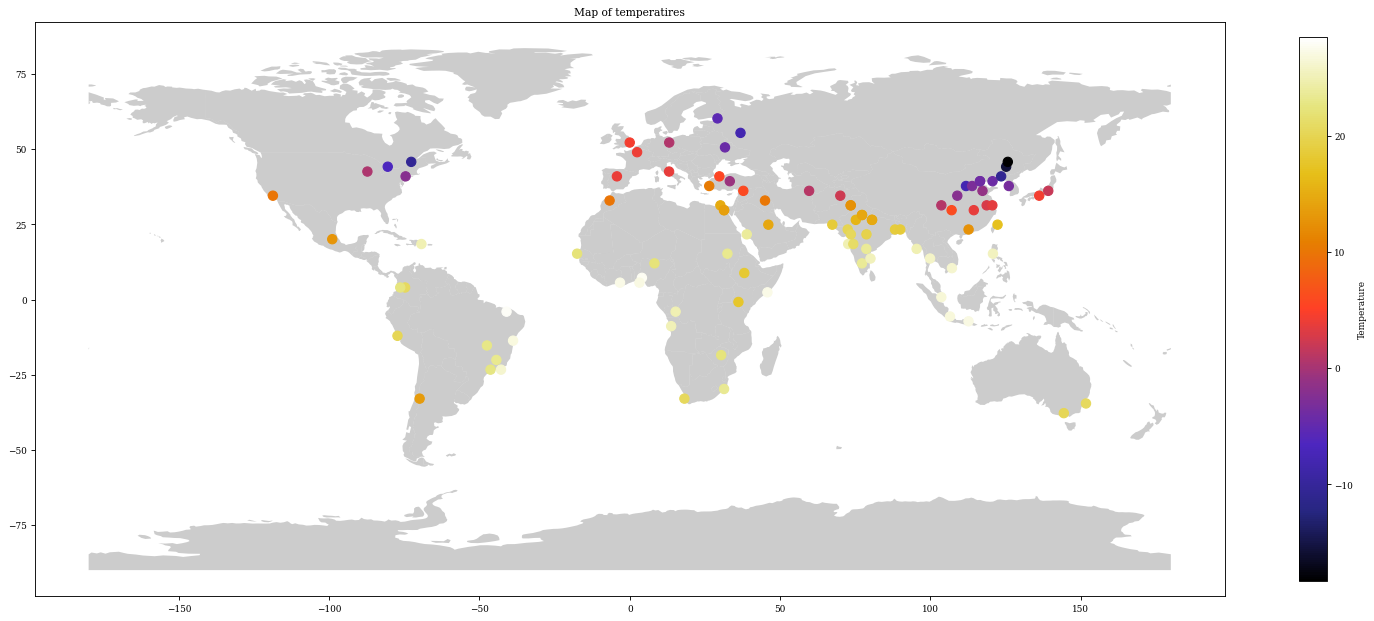

In [21]:
world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))

fig, ax = plt.subplots(figsize=(24, 18), dpi= 80)
world.plot(ax=ax, alpha=0.4, color="grey")
geo_df.plot(column="AverageTemperature", 
            ax=ax,  
            cmap="CMRmap", 
            legend=True,
            legend_kwds={"shrink":.5},
            markersize=70
            )

plt.title("Map of temperatires")

f=plt.gcf()
cax = f.get_axes()[1]
cax.set_ylabel("Temperature")